## Long story short: GLU activation works comparable to ReLU when using Batchnorm

Comparable in terms of model accuracy and model parameters count.
Without batchnorm LeakyReLU is better

In [1]:
import time
from typing import Optional, Tuple, List, Dict
import colorsys

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from enum import Enum

In [2]:
torch.cuda.is_available()

True

In [3]:
torch.__version__

'1.13.1+cu117'

In [4]:
from torchvision import datasets
from torchvision.transforms import ToTensor

train_data = datasets.MNIST(
    root='../models/mnist',
    train=True,
    transform=ToTensor(),
    download=True,
)

test_data = datasets.MNIST(
    root='../models/mnist',
    train=False,
    transform=ToTensor(),
    download=True,
)

In [5]:

class TrainHelper:
    @staticmethod
    def train(cnn: nn.Module,
              *,
              epochs: int,
              train_dataset: datasets.MNIST,
              test_dataset: Optional[datasets.MNIST] = None,
              print_results: bool = True,
              batch_size: int,
              device_name: str) -> List[float]:

        train_loader = torch.utils.data.DataLoader(train_dataset,
                                                   batch_size=batch_size,
                                                   shuffle=True,
                                                   num_workers=1)

        device = torch.device(device_name)

        cnn.to(device)
        cnn.train()

        optimizer = torch.optim.Adam(cnn.parameters(), lr=0.001)
        loss_func = nn.CrossEntropyLoss()

        eval_results: List[float] = []

        for epoch in range(epochs):
            for images, labels in train_loader:
                images = Variable(images.to(device))
                labels = Variable(labels.to(device))

                output = cnn(images)
                loss = loss_func(output, labels)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            if test_dataset is not None:
                eval_result = TrainHelper.test(cnn, test_dataset, device)
                eval_results.append(eval_result)
                if print_results:
                    print(f"epoch {epoch}, accuracy = {eval_result}, loss = {loss.detach()}")
                cnn.train()

        return eval_results

    @staticmethod
    def test(cnn: nn.Module, test_dataset: datasets.MNIST, device=None) -> float:
        cnn.eval()
        loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=1)
        correct = 0
        incorrect = 0

        for images, labels in loader:
            if device is not None:
                images = images.to(device)

            results = cnn(images)
            predictions = results.detach().cpu().numpy().argmax(axis=1)
            oks = (predictions == labels.numpy()).sum()
            correct += oks
            incorrect += len(predictions) - oks

        return correct / (correct + incorrect)

    @staticmethod
    def train_models(models: List[nn.Module], device_name: str = 'cuda') -> Tuple[int, float]:
        """
        generator yields pair (trainable parameters count, best accuracy) for each network
        :param device_name: 'cuda' or 'cpu'
        """
        assert len(models) > 0

        for model in models:
            start = time.time()
            eval_results = TrainHelper.train(
                cnn=model,
                epochs=20,
                train_dataset=train_data,
                test_dataset=test_data,
                batch_size=2048,
                device_name=device_name,
                print_results=False
            )
            end = time.time()
            best_acc = max(eval_results)
            params_count = TrainHelper.total_parameters_count(model)
            print(f"best accuracy = {best_acc}, parameters = {params_count}, training time = {end - start}")
            yield params_count, best_acc

    @staticmethod
    def total_parameters_count(model: nn.Module) -> int:
        return sum(np.prod(p.size()) for p in model.parameters())

    @staticmethod
    def print_parameters(model: nn.Module):
        print(f"total parameters = {TrainHelper.total_parameters_count(model)}")
        for p in model.parameters():
            print(f"size {np.prod(p.size())}: {p.size()}")

In [6]:
class Mode(Enum):
    RELU = 1
    GLU = 2
    SOFTMAX = 3
    SOFTMAX_4HEADS = 4

    @staticmethod
    def modes() -> Dict[str, 'Mode']:
        return {
            'relu': Mode.RELU,
            'glu': Mode.GLU,
            'softmax': Mode.SOFTMAX,
            'softmax4heads': Mode.SOFTMAX_4HEADS,
        }

class SoftmaxMultihead(nn.Module):
    def __init__(self, heads_count: int = 1):
        super().__init__()
        self.heads_count: int = 1
        self.softmax: nn.Module = nn.Softmax(dim=1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        b, c, h, w = x.size()
        assert c % (2 * self.heads_count) == 0
        mid = c // 2
        assert mid // self.heads_count > 1
        mask = x[:, :mid].reshape(b, mid // self.heads_count, self.heads_count, h, w)
        mask = self.softmax(mask).reshape(b, mid, h, w)
        return mask * x[:, mid:]

class MyConvModel(nn.Module):
    def __init__(self, channels: int, mode: Mode, use_bn: bool):
        super().__init__()

        self.mode: Mode = mode
        self.use_bn: bool = use_bn

        c = channels
        self.layers = nn.Sequential(
            *self.conv(1, c, kernel_size=3),  # 28 - 26
            *self.conv(c, c, kernel_size=3),  # 26 - 24
            nn.MaxPool2d(2),  # 24 - 12

            *self.conv(c, c * 2, kernel_size=3),  # 12 - 10
            *self.conv(c * 2, c * 2, kernel_size=3),  # 10 - 8
            nn.MaxPool2d(2),  # 8 - 4

            *self.conv(c * 2, c * 4, kernel_size=3),  # 4 - 2
            *self.conv(c * 4, c * 4, kernel_size=2),  # 2 - 1

            nn.Conv2d(c * 4, 10, kernel_size=1, padding='valid', bias=True),
            nn.Flatten(),
        )

    def conv(self, in_ch: int, out_ch: int, *, kernel_size) -> List[nn.Module]:
        if self.mode == Mode.RELU:
            if self.use_bn:
                return [
                    nn.Conv2d(in_ch, out_ch, kernel_size=kernel_size, padding='valid', bias=False),
                    nn.BatchNorm2d(out_ch),
                    nn.LeakyReLU(0.1)
                ]
            else:
                return [
                    nn.Conv2d(in_ch, out_ch, kernel_size=kernel_size, padding='valid', bias=True),
                    nn.LeakyReLU(0.1)
                ]
        
        if self.mode == Mode.GLU:
            activation = nn.GLU(dim=1)
        elif self.mode == Mode.SOFTMAX:
            activation = SoftmaxMultihead(1)        
        elif self.mode == Mode.SOFTMAX_4HEADS:
            activation = SoftmaxMultihead(4)
        else:
            raise ValueError(f"unexpected mode {self.mode}")
            
        if self.use_bn:
            return [
                nn.Conv2d(in_ch, out_ch * 2, kernel_size=kernel_size, padding='valid', bias=False),
                nn.BatchNorm2d(out_ch * 2),
                activation,
            ]
        else:
            return [
                nn.Conv2d(in_ch, out_ch * 2, kernel_size=kernel_size, padding='valid', bias=True),
                activation,
            ]
            
    def forward(self, x: torch.Tensor):
        return self.layers(x)

In [7]:
def run_networks(repeats: int, use_bn: bool) -> Dict[str, List[Tuple[int, int]]]:
    results = {}

    for name, mode in Mode.modes().items():        
        if name not in results:
            results[name] = []
        for i in range(repeats):
            print(f'start train network with {name}, repeat {i}')
            
            models = [MyConvModel(n, mode, use_bn) for n in [8, 12, 16, 24, 32]]

            for pair in TrainHelper.train_models(models):
                results[name].append(pair)

    return results

results_bn = run_networks(use_bn=True, repeats=4)

start train network with relu, repeat 0
best accuracy = 0.9914, parameters = 13362, training time = 85.80372834205627
best accuracy = 0.9937, parameters = 29590, training time = 83.21871590614319
best accuracy = 0.9934, parameters = 52186, training time = 83.35354399681091
best accuracy = 0.9947, parameters = 116482, training time = 83.77545595169067
best accuracy = 0.9956, parameters = 206250, training time = 84.896968126297
start train network with relu, repeat 1
best accuracy = 0.9932, parameters = 13362, training time = 85.00980830192566
best accuracy = 0.9934, parameters = 29590, training time = 84.94960427284241
best accuracy = 0.9948, parameters = 52186, training time = 84.84648275375366
best accuracy = 0.995, parameters = 116482, training time = 84.97444558143616
best accuracy = 0.9958, parameters = 206250, training time = 85.17760729789734
start train network with relu, repeat 2
best accuracy = 0.993, parameters = 13362, training time = 83.94891357421875
best accuracy = 0.9937

/tmp/ipykernel_617307/13160794.py:11: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(params_counts, accuracies, c=color, label=name)


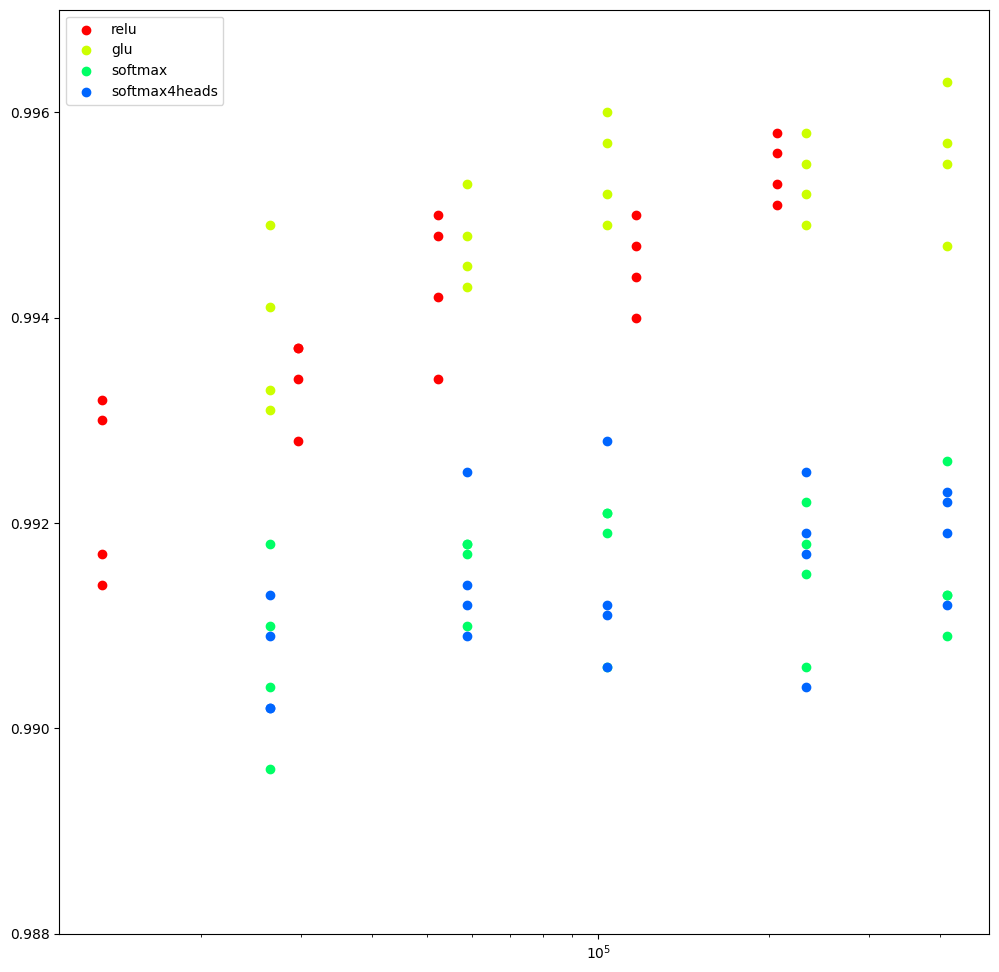

In [17]:
plt.rcParams['figure.figsize'] = [12, 12]
fig, ax = plt.subplots()
ax.set_xscale("log")
ax.set_ylim(0.988, 0.997)

for i, (name, r) in enumerate(results_bn.items()):
    params_counts = [p[0] for p in r]
    accuracies = [p[1] for p in r]

    color = colorsys.hsv_to_rgb(i * 0.2, 1.0, 1.0)
    ax.scatter(params_counts, accuracies, c=color, label=name)

ax.legend()
plt.show()

In [9]:
results_no_bn = run_networks(repeats=4, use_bn=False)

start train network with relu, repeat 0
best accuracy = 0.9772, parameters = 13250, training time = 85.96172189712524
best accuracy = 0.9846, parameters = 29422, training time = 85.92859840393066
best accuracy = 0.9885, parameters = 51962, training time = 85.81628060340881
best accuracy = 0.9899, parameters = 116146, training time = 85.62074518203735
best accuracy = 0.9907, parameters = 205802, training time = 86.31692910194397
start train network with relu, repeat 1
best accuracy = 0.9825, parameters = 13250, training time = 86.160724401474
best accuracy = 0.9831, parameters = 29422, training time = 85.69887804985046
best accuracy = 0.9871, parameters = 51962, training time = 85.44513416290283
best accuracy = 0.9905, parameters = 116146, training time = 85.65231013298035
best accuracy = 0.9911, parameters = 205802, training time = 85.65886211395264
start train network with relu, repeat 2
best accuracy = 0.9776, parameters = 13250, training time = 85.52700114250183
best accuracy = 0.98

/tmp/ipykernel_617307/914445671.py:11: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(params_counts, accuracies, c=color, label=name)


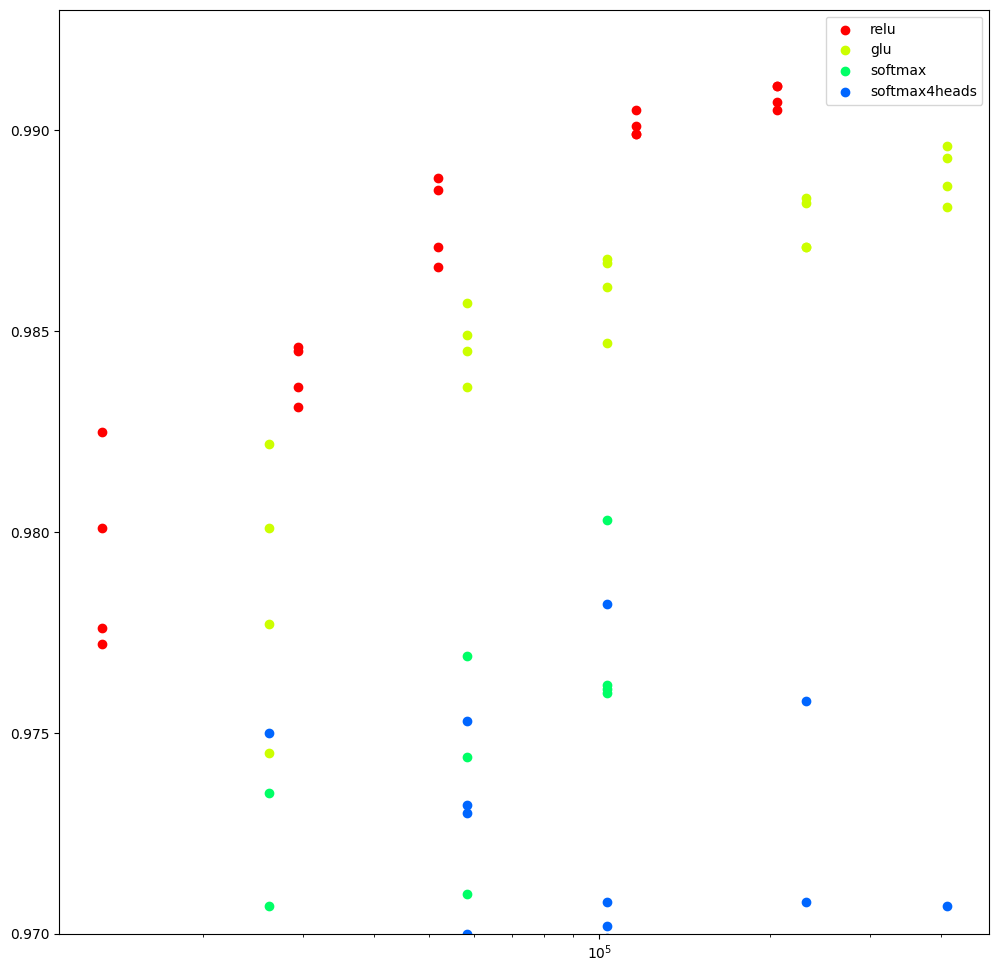

In [15]:
plt.rcParams['figure.figsize'] = [12, 12]
fig, ax = plt.subplots()
ax.set_xscale("log")
ax.set_ylim(0.97, 0.993)

for i, (name, r) in enumerate(results_no_bn.items()):
    params_counts = [p[0] for p in r]
    accuracies = [p[1] for p in r]

    color = colorsys.hsv_to_rgb(i * 0.2, 1.0, 1.0)
    ax.scatter(params_counts, accuracies, c=color, label=name)

ax.legend()
plt.show()